In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
import yfinance as yf
from IPython.core.display import HTML
from matplotlib.animation import FuncAnimation
from pyro.infer import MCMC, NUTS
from scipy.stats import beta

sns.set_palette("Set2")

## Bandits

In [2]:
# The original implementation does not use probabilistic programming so
# we will just have some fun translating it to a more lightweight version

In [3]:
np.random.seed(25)

n_bandits = 5
n_iterations = 500

win_probs = np.random.uniform(size=n_bandits)

choices = np.zeros(n_iterations)
wins = np.zeros([n_iterations, n_bandits])
trials = np.zeros([n_iterations, n_bandits])

for i in range(1, n_iterations):
    choice = np.argmax(np.random.beta(1 + wins[i - 1], 1 + trials[i - 1] - wins[i - 1]))

    choices[i - 1] = choice
    trials[i:, choice] += 1
    wins[i:, choice] += np.random.uniform() < win_probs[choice]

In [4]:
# Let's animate the results
iteration_i = 0
xx = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 6))

lines = []

for bandit_j in range(n_bandits):
    color = sns.color_palette()[bandit_j]

    lines.append(
        ax.plot(
            xx,
            beta.pdf(
                xx,
                1 + wins[iteration_i][bandit_j],
                1 + trials[iteration_i][bandit_j] - wins[iteration_i][bandit_j],
            ),
            color=color,
        )[0]
    )

    ax.axvline(x=win_probs[bandit_j], color=color, linestyle="--")


ax.set_title(f"Iteration {iteration_i + 1}")
ax.set_xlim((0, 1))
ax.set_ylim((0, 10))


def update(iteration_i):
    for bandit_j, ln in enumerate(lines):
        ln.set_data(
            xx,
            beta.pdf(
                xx,
                1 + wins[iteration_i][bandit_j],
                1 + trials[iteration_i][bandit_j] - wins[iteration_i][bandit_j],
            ),
        )
    ax.set_title(f"Iteration {iteration_i + 1}")
    return (lines[0],)


animation = FuncAnimation(fig, update, frames=np.arange(0, n_iterations), blit=True, interval=0.1)

animation.save("output/bandits.gif", dpi=150, savefig_kwargs={"facecolor": "#FFFFFF"})

plt.close()

In [5]:
HTML("<img src=output/bandits.gif>")

In [6]:
bandit_regret = (np.max(win_probs) - win_probs[choices.astype(int)]).cumsum()
random_regret = (np.max(win_probs) - win_probs[np.random.choice(n_bandits, size=n_iterations)]).cumsum()

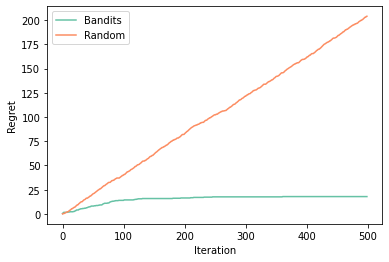

In [7]:
fig, ax = plt.subplots()

ax.plot(np.arange(n_iterations), bandit_regret, label="Bandits")
ax.plot(np.arange(n_iterations), random_regret, label="Random")

ax.legend()
ax.set_ylabel("Regret")
ax.set_xlabel("Iteration")

plt.show()

## Stock prices

In [8]:
n_observations = 100

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

start_date = "2012-09-01"
end_date = "2015-04-27"

data = yf.download(stocks, start_date, end_date)

[*********************100%***********************]  4 of 4 completed


In [9]:
close_values = data["Adj Close"][stocks].pct_change().iloc[-n_observations:].values

In [10]:
def stock_model(close_values):
    # We will create our covariance matrix by hand
    corr_matrix = pyro.sample("lkj", dist.LKJ(dim=close_values.shape[1], concentration=1))
    sds = pyro.sample("sds", dist.Exponential(rate=0.01).expand([close_values.shape[1]]))
    cov_matrix = torch.diag(sds) @ corr_matrix @ torch.diag(sds)
    locs = pyro.sample("locs", dist.Normal(loc=0, scale=1).expand([close_values.shape[1]]))

    with pyro.plate("plate", close_values.shape[0]):
        pyro.sample(
            "close_values_sampled", dist.MultivariateNormal(loc=locs, covariance_matrix=cov_matrix), obs=close_values
        )

In [11]:
nuts_kernel = NUTS(stock_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(torch.tensor(close_values).float())

Sample: 100%|██████████| 1200/1200 [06:59,  2.86it/s, step size=8.87e-02, acc. prob=0.939]


In [12]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

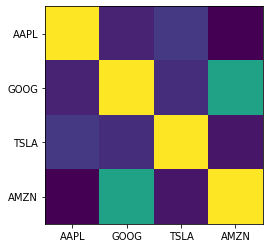

In [13]:
fig, ax = plt.subplots()

ax.imshow(mcmc_samples["lkj"].mean(axis=0))

ax.set_xticks(range(4))
ax.set_xticklabels(stocks)
ax.set_yticks(range(4))
ax.set_yticklabels(stocks)

plt.show()

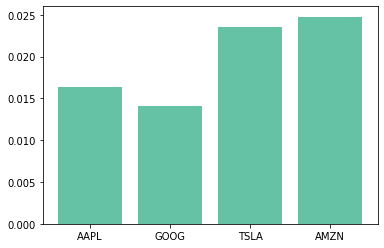

In [14]:
fig, ax = plt.subplots()

ax.bar(stocks, mcmc_samples["sds"].mean(axis=0))

plt.show()